## Analysing Sentiments in COVID-19 Tweets for Predicting the 2020 S&P 500 Crash

In this personal project, I perform sentiment analysis on COVID-19 tweets, from January 2020 to June 2020, using the RoBERTa language model. The aim is to see whether tweet sentiment serves as a good predictor for the aggregate stock market; the S&P 500 index will be used as a proxy.

I will examine aggregate data on S&P 50 trends as well as average daily tweet sentiment. Finally, I intend to perform a regression analysis to ascertain the strength of tweet sentiment as a predictor, and discuss some causality interpretations.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sentiment_analysis import *
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import random
from datetime import datetime

%config InlineBackend.figure_formats = ["svg"]

## Tweet Processing and Sentiment Analysis

### March 2 to March 16 Tweets

Link to dataset: https://github.com/malinowakrew/text_classifier_sentiment

In [2]:
raw_mar_df = pd.read_csv("data/mar.csv")

raw_mar_df[["TweetAt", "OriginalTweet"]]

,TweetAt,OriginalTweet
0,02-03-2020,TRENDING: New Yorkers encounter empty supermar...
1,02-03-2020,When I couldn't find hand sanitizer at Fred Me...
2,02-03-2020,Find out how you can protect yourself and love...
3,02-03-2020,#Panic buying hits #NewYork City as anxious sh...
4,03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...
...,...,...
3793,16-03-2020,Meanwhile In A Supermarket in Israel -- People...
3794,16-03-2020,Did you panic buy a lot of non-perishable item...
3795,16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...
3796,16-03-2020,Gov need to do somethings instead of biar je r...


#### Display processed tweets in a dataframe with their corresponding dates:

In [3]:
mar_df = raw_mar_df[["TweetAt", "OriginalTweet"]].copy()
mar_df = mar_df.rename(columns={"TweetAt": "Date", "OriginalTweet": "Tweet"})
# tweet_processing replaces all "@"s with the generic "@user" and all links with "http"
mar_df["Tweet"] = mar_df["Tweet"].apply(tweet_processing)

mar_df

,Date,Tweet
0,02-03-2020,TRENDING: New Yorkers encounter empty supermar...
1,02-03-2020,When I couldn't find hand sanitizer at Fred Me...
2,02-03-2020,Find out how you can protect yourself and love...
3,02-03-2020,#Panic buying hits #NewYork City as anxious sh...
4,03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...
...,...,...
3793,16-03-2020,Meanwhile In A Supermarket in Israel -- People...
3794,16-03-2020,Did you panic buy a lot of non-perishable item...
3795,16-03-2020,Asst Prof of Economics @user was on @user talk...
3796,16-03-2020,Gov need to do somethings instead of biar je r...


##### Cell below applies the RoBERTa model to classify all March tweets (sentiments saved to Excel):

In [4]:
#mar_sentiments = mar_df["Tweet"].apply(classify)
#mar_sentiments.to_excel("sentiments/mar2-mar16.xlsx")

In [5]:
mar_df["RoBERTa Sentiment"] = pd.read_excel("sentiments/mar2-mar16.xlsx", index_col=0)
mar_df["Date"] = pd.to_datetime(mar_df["Date"], format="%d-%m-%Y")

mar_df

,Date,Tweet,RoBERTa Sentiment
0,2020-03-02,TRENDING: New Yorkers encounter empty supermar...,"{'Negative': 0.48240444, 'Neutral': 0.4544737,..."
1,2020-03-02,When I couldn't find hand sanitizer at Fred Me...,"{'Negative': 0.75834924, 'Neutral': 0.20829795..."
2,2020-03-02,Find out how you can protect yourself and love...,"{'Negative': 0.17228049, 'Neutral': 0.75208455..."
3,2020-03-02,#Panic buying hits #NewYork City as anxious sh...,"{'Negative': 0.36858848, 'Neutral': 0.54294467..."
4,2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,"{'Negative': 0.47861266, 'Neutral': 0.46391496..."
...,...,...,...
3793,2020-03-16,Meanwhile In A Supermarket in Israel -- People...,"{'Negative': 0.010109048, 'Neutral': 0.4276002..."
3794,2020-03-16,Did you panic buy a lot of non-perishable item...,"{'Negative': 0.14297354, 'Neutral': 0.75276977..."
3795,2020-03-16,Asst Prof of Economics @user was on @user talk...,"{'Negative': 0.054245595, 'Neutral': 0.8577724..."
3796,2020-03-16,Gov need to do somethings instead of biar je r...,"{'Negative': 0.8149176, 'Neutral': 0.16968678,..."


In [6]:
# Convert string (with dict inside) to dict
mar_df["RoBERTa Sentiment"] = mar_df["RoBERTa Sentiment"].apply(ast.literal_eval)

# Extract the "Negative" values from the sentiment analysis
mar_neg_vals = mar_df["RoBERTa Sentiment"].apply(lambda senti_dict: senti_dict["Negative"])

# Create a new DataFrame with the "Date" and "Negative" values
mar_df_neg = pd.DataFrame({"Date": mar_df["Date"], "Negative": mar_neg_vals})

# Calculate the average "Negative" value for each date
mar_avg_neg = mar_df_neg.groupby("Date")[["Negative"]].mean()

mar_avg_neg

,Negative
Date,
2020-03-02,0.445406
2020-03-03,0.450559
2020-03-04,0.461016
2020-03-05,0.364844
2020-03-06,0.341433
2020-03-07,0.575618
2020-03-08,0.577915
2020-03-09,0.458212
2020-03-10,0.443669


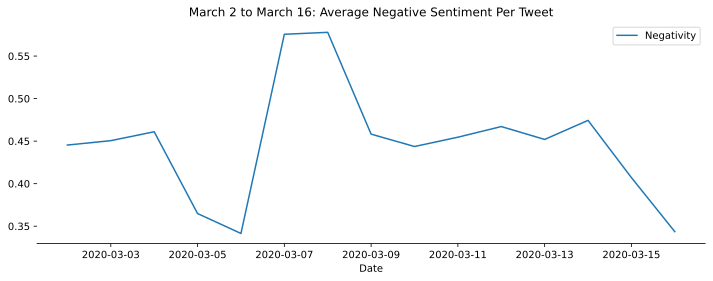

In [7]:
plt.figure(figsize=(12, 4))
plt.title("March 2 to March 16: Average Negative Sentiment Per Tweet")
sns.lineplot(data=mar_avg_neg)
sns.despine(left=True)
plt.legend(["Negativity"]);

### March 17 to June 20 Tweets

__Note__: March 17 to June 20 tweets will be obtained from two datasets. 

Link to first dataset: https://www.kaggle.com/datasets/arunavakrchakraborty/covid19-twitter-dataset

Link to second dataset: https://www.kaggle.com/datasets/prakashniroula/245k-tweets-of-covid-19?select=uncleaned_245k_tweets.csv

The first contains tweets from April 19 to June 20, and the second contains tweets from January 1 to June 29. The second dataset was obtained at a later date, at a time where sentiment analysis was already performed on the tweets from the first dataset (April 19 to June 20). 

The second dataset will be used to fill in the gaps in the March 17 to April 18 period, as well as to analyse tweets between January 1 and March 1, which will be done further down in this notebook.

In [8]:
raw_mar_jun_df1 = pd.read_csv("data/apr_jun.csv")
raw_jan_jun_df = pd.read_csv("data/jan_jun.csv")

raw_jan_jun_df["date"] = raw_jan_jun_df["date"].str[:10]
raw_jan_jun_df["date"] = pd.to_datetime(raw_jan_jun_df["date"], format="%Y-%m-%d")
raw_mar_jun_df2 = raw_jan_jun_df[(raw_jan_jun_df["date"] >= datetime(2020, 3, 17)) & (raw_jan_jun_df["date"] <= datetime(2020, 4, 18))]

# Change format of raw_mar_jun_df2 to that of raw_mar_jun_df1 before concatenation
raw_mar_jun_df2 = raw_mar_jun_df2.rename(columns={"content": "original_text", 
                                "date": "created_at", 
                                "like_count": "favorite_count",
                                })

# Convert datetime dates back to string for readability (removing unnecessary time component)
raw_mar_jun_df2["created_at"] = raw_mar_jun_df2["created_at"].dt.strftime("%Y-%m-%d")
raw_mar_jun_df2["created_at"] = raw_mar_jun_df2["created_at"].str[:10]

raw_mar_jun_df = pd.concat([raw_mar_jun_df1, raw_mar_jun_df2], ignore_index=True).sort_values("created_at")
raw_mar_jun_df = raw_mar_jun_df[raw_mar_jun_df["original_text"].notna()]

raw_mar_jun_df[["created_at", "original_text"]]

,created_at,original_text
144176,2020-03-17,PM Scott Morrison has told people to stop hoar...
144078,2020-03-17,Grilling during the #CoronaVirus pandemic http...
144079,2020-03-17,What are some Left mutual aid efforts going on...
144080,2020-03-17,Georgia college students finish semester onlin...
144081,2020-03-17,It comes after Tesco tweeted out a message urg...
...,...,...
143425,2020-06-20,RT @LOLGOP: Nothing will cost us more than tri...
143426,2020-06-20,RT @rickwtyler: Six Trump staff at Tulsa rally...
143427,2020-06-20,RT @Shambha49567401: Need B+Iive plasma of a c...
143429,2020-06-20,RT @business: LATEST: Six members of the Trump...


#### Display processed tweets in a dataframe with their corresponding dates:

In [9]:
mar_jun_df = raw_mar_jun_df[["created_at", "original_text"]].copy()
mar_jun_df = mar_jun_df.rename(columns={"created_at": "Date", "original_text": "Tweet"})
mar_jun_df = mar_jun_df.dropna()
# tweet_processing replaces all "@"s with the generic "@user" and all links with "http"
mar_jun_df["Tweet"] = mar_jun_df["Tweet"].apply(tweet_processing)

mar_jun_df

,Date,Tweet
144176,2020-03-17,PM Scott Morrison has told people to stop hoar...
144078,2020-03-17,Grilling during the #CoronaVirus pandemic http...
144079,2020-03-17,What are some Left mutual aid efforts going on...
144080,2020-03-17,Georgia college students finish semester onlin...
144081,2020-03-17,It comes after Tesco tweeted out a message urg...
...,...,...
143425,2020-06-20,RT @user Nothing will cost us more than trilli...
143426,2020-06-20,RT @user Six Trump staff at Tulsa rally positi...
143427,2020-06-20,RT @user Need B+Iive plasma of a cured COVID -...
143429,2020-06-20,RT @user LATEST: Six members of the Trump re-e...


#### Choose around 3000 tweets through further sampling (stratified random), due to hardware limitations, from March 17 to June 20 for classification:

In [10]:
# Desired overall tweet sample size (will not be exact due to rounding)
n = 3000
# Sample sizes for each day weighted by number of tweets
mar_jun_sample_sizes = (n * mar_jun_df["Date"].value_counts(normalize=True, sort=False)).apply(round) 
date_grouped = mar_jun_df.groupby("Date")
    
def random_sample(group, daily_sample_sizes):
    # Get the date for each group
    date = group["Date"].iloc[0]  
    sample_size = daily_sample_sizes[date]  
    random.seed(1)
    # Choose a random sample of tweets from each date
    random_indices = random.sample(range(len(group)), sample_size)
    return group.iloc[random_indices]

mar_jun_sample = date_grouped.apply(lambda group: random_sample(group, mar_jun_sample_sizes)).reset_index(drop=True)

mar_jun_sample

,Date,Tweet
0,2020-03-17,The dire situation in Italy is evidence that #...
1,2020-03-17,#COVID19 frontline in the NHS\n\nspoken to an ...
2,2020-03-17,#SaudiArabia calls to convene an extraordinary...
3,2020-03-17,.@LindseyGrahamSC hasn’t earned an honest day’...
4,2020-03-17,"""Stop hoarding. I can't be more blunt about it..."
...,...,...
2983,2020-06-20,@user I'm shocked aren't you? 🤔 #TrumpKlanRall...
2984,2020-06-20,RT @user Eligible CAF members working directly...
2985,2020-06-20,"@user Yeah, I’ll bet you’re going to have them..."
2986,2020-06-20,@user @user to fool yourself for covid-19?


##### Cell below applies the RoBERTa model to classify the random subset of March 17 to June 20 tweets (sentiments saved to Excel):

In [11]:
#mar_jun_sentiments = mar_jun_sample["Tweet"].apply(classify)
#mar_jun_sentiments.to_excel("sentiments/mar17-jun20.xlsx")

In [12]:
mar_jun_sample["RoBERTa Sentiment"] = pd.read_excel("sentiments/mar17-jun20.xlsx", index_col=0)
mar_jun_sample["Date"] = pd.to_datetime(mar_jun_sample["Date"], format="%Y-%m-%d")

mar_jun_sample

,Date,Tweet,RoBERTa Sentiment
0,2020-03-17,The dire situation in Italy is evidence that #...,"{'Negative': 0.77124846, 'Neutral': 0.20449166..."
1,2020-03-17,#COVID19 frontline in the NHS\n\nspoken to an ...,"{'Negative': 0.52397925, 'Neutral': 0.42259458..."
2,2020-03-17,#SaudiArabia calls to convene an extraordinary...,"{'Negative': 0.0026455757, 'Neutral': 0.307980..."
3,2020-03-17,.@LindseyGrahamSC hasn’t earned an honest day’...,"{'Negative': 0.9123801, 'Neutral': 0.08080706,..."
4,2020-03-17,"""Stop hoarding. I can't be more blunt about it...","{'Negative': 0.8980231, 'Neutral': 0.09259069,..."
...,...,...,...
2983,2020-06-20,@user I'm shocked aren't you? 🤔 #TrumpKlanRall...,"{'Negative': 0.49062735, 'Neutral': 0.4662029,..."
2984,2020-06-20,RT @user Eligible CAF members working directly...,"{'Negative': 0.18554261, 'Neutral': 0.764041, ..."
2985,2020-06-20,"@user Yeah, I’ll bet you’re going to have them...","{'Negative': 0.25095478, 'Neutral': 0.62057877..."
2986,2020-06-20,@user @user to fool yourself for covid-19?,"{'Negative': 0.5295874, 'Neutral': 0.4433052, ..."


In [13]:
# Convert string (with dict inside) to dict
mar_jun_sample["RoBERTa Sentiment"] = mar_jun_sample["RoBERTa Sentiment"].apply(ast.literal_eval)

# Extract the "Negative" values from the sentiment analysis
mar_jun_neg_vals = mar_jun_sample["RoBERTa Sentiment"].apply(lambda senti_dict: senti_dict["Negative"])

# Create a new DataFrame with the "Date" and "Negative" values
mar_jun_sample_neg = pd.DataFrame({"Date": mar_jun_sample["Date"], "Negative": mar_jun_neg_vals})

# Calculate the average "Negative" value for each date
mar_jun_avg_neg = mar_jun_sample_neg.groupby("Date")[["Negative"]].mean()

mar_jun_avg_neg

,Negative
Date,
2020-03-17,0.621655
2020-03-18,0.181110
2020-03-19,0.199451
2020-03-20,0.285320
2020-03-21,0.506762
...,...
2020-06-14,0.321699
2020-06-15,0.302330
2020-06-17,0.248629


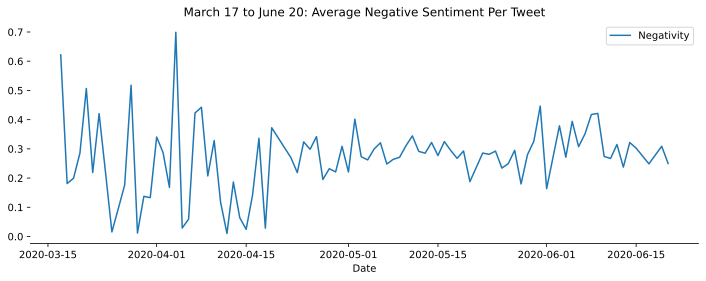

In [14]:
plt.figure(figsize=(12, 4))
plt.title("March 17 to June 20: Average Negative Sentiment Per Tweet")
sns.lineplot(data=mar_jun_avg_neg)
sns.despine(left=True)
plt.legend(["Negativity"]);

### January 1 to March 1 Tweets

Link to dataset: https://www.kaggle.com/datasets/prakashniroula/245k-tweets-of-covid-19?select=uncleaned_245k_tweets.csv

Obtain tweets between January 1 and March 1 from the January-June dataset:

In [15]:
raw_jan_jun_df = pd.read_csv("data/jan_jun.csv")
raw_jan_jun_df["date"] = raw_jan_jun_df["date"].str[:10]
raw_jan_jun_df["date"] = pd.to_datetime(raw_jan_jun_df["date"], format="%Y-%m-%d")
# Only consider Jan 1-Mar 1 tweets
raw_jan_mar_df = raw_jan_jun_df[raw_jan_jun_df["date"] <= datetime(2020, 3, 1)]

raw_jan_mar_df[["date", "content"]]

,date,content
0,2020-01-01,1/ *NEW PAPERS ALERT*\n\nVery proud to share t...
1,2020-01-02,"Drawing from actual events, #Event201 identifi..."
2,2020-01-05,Interesting article @PNAS on whether the Justi...
3,2020-01-05,@arambaut @WHO But batteries of tests have bee...
4,2020-01-06,#Pandemic players: what do you do if you draw ...
...,...,...
11829,2020-03-01,TOMORROW: The EU Commission will hold a press ...
11830,2020-03-01,In 236 years of #Catholicism in South Korea ch...
11831,2020-03-01,ICYMI: “When Trump accuses Democrats of hyping...
11832,2020-03-01,Here's why Singapore's response to the #corona...


#### Display processed tweets in a dataframe with their corresponding dates:

In [16]:
jan_mar_df = raw_jan_mar_df[["date", "content"]].copy()
jan_mar_df = jan_mar_df.rename(columns={"date": "Date", "content": "Tweet"})
jan_mar_df = jan_mar_df.dropna()
# tweet_processing replaces all "@"s with the generic "@user" and all links with "http"
jan_mar_df["Tweet"] = jan_mar_df["Tweet"].apply(tweet_processing)

jan_mar_df

,Date,Tweet
0,2020-01-01,1/ *NEW PAPERS ALERT*\n\nVery proud to share t...
1,2020-01-02,"Drawing from actual events, #Event201 identifi..."
2,2020-01-05,Interesting article @user on whether the Justi...
3,2020-01-05,@user @user But batteries of tests have been p...
4,2020-01-06,#Pandemic players: what do you do if you draw ...
...,...,...
11829,2020-03-01,TOMORROW: The EU Commission will hold a press ...
11830,2020-03-01,In 236 years of #Catholicism in South Korea ch...
11831,2020-03-01,ICYMI: “When Trump accuses Democrats of hyping...
11832,2020-03-01,Here's why Singapore's response to the #corona...


#### Choose around 3000 tweets through further sampling (stratified random), due to hardware limitations, from January 1 to March 1 for classification:

In [17]:
# Desired overall tweet sample size (will not be exact due to rounding)
m = 3000
# Sample sizes for each day weighted by number of tweets
jan_mar_sample_sizes = (m * jan_mar_df["Date"].value_counts(normalize=True, sort=False)).apply(round) 
date_grouped = jan_mar_df.groupby("Date")
jan_mar_sample = date_grouped.apply(lambda group: random_sample(group, jan_mar_sample_sizes)).reset_index(drop=True)

jan_mar_sample

,Date,Tweet
0,2020-01-05,Interesting article @user on whether the Justi...
1,2020-01-07,Preparing for the Next #Pandemic — The @user G...
2,2020-01-08,Given that both #Wuhan and #HongKong's numbers...
3,2020-01-09,A novel #coronavirus is a new strain of the vi...
4,2020-01-09,Chinese authorities have made a preliminary de...
...,...,...
2997,2020-03-01,Here's what's happening on 1010 WINS:\n-2 more...
2998,2020-03-01,Hello fellow #IndigenousHealth tweeps. There's...
2999,2020-03-01,#CoronaVirusUpdate #COVID #Corona #kuwait #GCC...
3000,2020-03-01,Within 12 hours of the case presenting at the ...


##### Cell below applies the RoBERTa model to classify all Jan-Feb tweets (sentiments saved to Excel):

In [18]:
#jan_mar_sentiments = jan_mar_sample["Tweet"].apply(classify)
#jan_mar_sentiments.to_excel("sentiments/jan1-mar1.xlsx")

In [19]:
jan_mar_sample["RoBERTa Sentiment"] = pd.read_excel("sentiments/jan1-mar1.xlsx", index_col=0)

jan_mar_sample

,Date,Tweet,RoBERTa Sentiment
0,2020-01-05,Interesting article @user on whether the Justi...,"{'Negative': 0.051573448, 'Neutral': 0.3902184..."
1,2020-01-07,Preparing for the Next #Pandemic — The @user G...,"{'Negative': 0.32618505, 'Neutral': 0.6277443,..."
2,2020-01-08,Given that both #Wuhan and #HongKong's numbers...,"{'Negative': 0.35782298, 'Neutral': 0.54605675..."
3,2020-01-09,A novel #coronavirus is a new strain of the vi...,"{'Negative': 0.3370279, 'Neutral': 0.6345147, ..."
4,2020-01-09,Chinese authorities have made a preliminary de...,"{'Negative': 0.11339166, 'Neutral': 0.81838715..."
...,...,...,...
2997,2020-03-01,Here's what's happening on 1010 WINS:\n-2 more...,"{'Negative': 0.41302812, 'Neutral': 0.54170537..."
2998,2020-03-01,Hello fellow #IndigenousHealth tweeps. There's...,"{'Negative': 0.004206084, 'Neutral': 0.3317168..."
2999,2020-03-01,#CoronaVirusUpdate #COVID #Corona #kuwait #GCC...,"{'Negative': 0.2711615, 'Neutral': 0.68644994,..."
3000,2020-03-01,Within 12 hours of the case presenting at the ...,"{'Negative': 0.013753897, 'Neutral': 0.8468478..."


In [20]:
# Convert string (with dict inside) to dict
jan_mar_sample["RoBERTa Sentiment"] = jan_mar_sample["RoBERTa Sentiment"].apply(ast.literal_eval)

# Extract the "Negative" values from the sentiment analysis
jan_mar_neg_vals = jan_mar_sample["RoBERTa Sentiment"].apply(lambda senti_dict: senti_dict["Negative"])

# Create a new DataFrame with the "Date" and "Negative" values
jan_mar_sample_neg = pd.DataFrame({"Date": jan_mar_sample["Date"], "Negative": jan_mar_neg_vals})

# Calculate the average "Negative" value for each date
jan_mar_avg_neg = jan_mar_sample_neg.groupby("Date")[["Negative"]].mean()

jan_mar_avg_neg.head()

,Negative
Date,
2020-01-05,0.051573
2020-01-07,0.326185
2020-01-08,0.357823
2020-01-09,0.283828
2020-01-10,0.200135


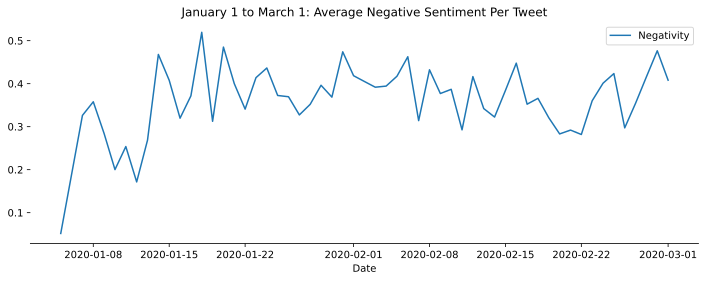

In [21]:
plt.figure(figsize=(12, 4))
plt.title("January 1 to March 1: Average Negative Sentiment Per Tweet")
sns.lineplot(data=jan_mar_avg_neg)
sns.despine(left=True)
plt.legend(["Negativity"]);

#### All three graphs side by side:

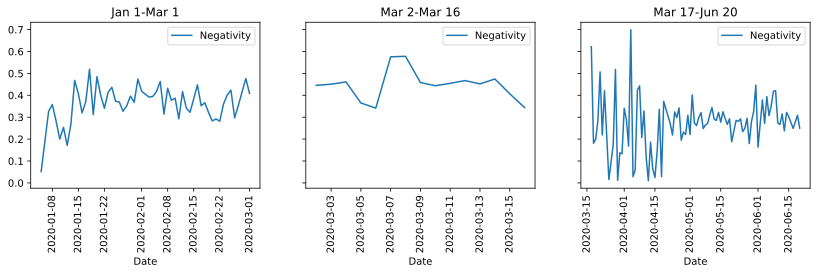

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14, 3))

sns.lineplot(data=jan_mar_avg_neg, ax=ax[0])
sns.lineplot(data=mar_avg_neg, ax=ax[1])
sns.lineplot(data=mar_jun_avg_neg, ax=ax[2])

ax[0].title.set_text("Jan 1-Mar 1")
ax[1].title.set_text("Mar 2-Mar 16")
ax[2].title.set_text("Mar 17-Jun 20")
for i in range(3):
    ax[i].legend(["Negativity"])
    ax[i].tick_params(axis="x", rotation=90);

In [23]:
combined_avg_neg = pd.concat([jan_mar_avg_neg, mar_avg_neg, mar_jun_avg_neg])

combined_avg_neg

,Negative
Date,
2020-01-05,0.051573
2020-01-07,0.326185
2020-01-08,0.357823
2020-01-09,0.283828
2020-01-10,0.200135
...,...
2020-06-14,0.321699
2020-06-15,0.302330
2020-06-17,0.248629


In [24]:
combined_avg_neg.describe()

,Negative
count,161.000000
mean,0.318477
std,0.121341
min,0.010238
25%,0.263974
50%,0.321699
75%,0.401541
max,0.698950


April 4 2020 was the day of the highest average negative sentiment per tweet between January 1 to June 20:

In [25]:
combined_avg_neg[combined_avg_neg["Negative"] == combined_avg_neg["Negative"].max()]

,Negative
Date,
2020-04-04,0.69895


April 12 was the day of the lowest average negative sentiment per tweet between January 1 to June 20:

In [26]:
combined_avg_neg[combined_avg_neg["Negative"] == combined_avg_neg["Negative"].min()]

,Negative
Date,
2020-04-12,0.010238


Both the highest and lowest average negative tweet sentiment values occur in April, right after the S&P 500 index starts to recover.

#### Combined plot:

Graph of average negative sentiment per tweet between January 1 and June 20 shown below:

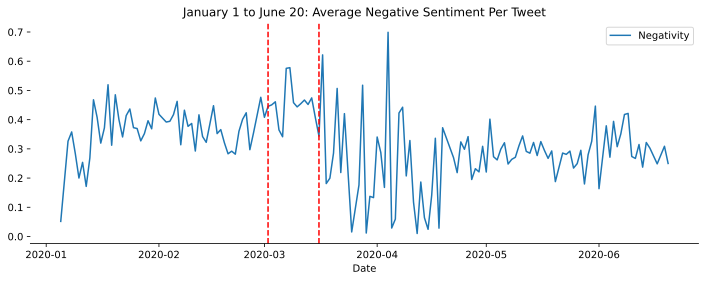

In [27]:
plt.figure(figsize=(12, 4))
plt.title("January 1 to June 20: Average Negative Sentiment Per Tweet")
sns.lineplot(data=combined_avg_neg)
sns.despine(left=True)
plt.axvline(datetime(2020, 3, 2), color="red", linestyle="--")
plt.axvline(datetime(2020, 3, 16), color="red", linestyle="--")
plt.legend(["Negativity"]);

The region between the two dotted red lines denotes the period in which the S&P 500 index was in freefall (Mar 2-Mar 6 2020). 

**Analysis**:

- There is a clear increase in tweet sentiment volatility during the period immediately after the S&P 500 index begins its recovery.

- One plausible hypothesis for this phenomenon may be attributed to a heightened range of sentiments, fuelled by the stock market crash, expressed by Twitter users regarding their outlook on the future. While some individuals express a higher degree of optimism, others convey a more pessimistic sentiment.

- While the presence of a higher volume of sarcastic tweets, which might be erroneously categorised as positive sentiment by the RoBERTa model, could contribute to the decrease in negative tweet sentiment, it is important to note that this factor alone may not fully account for the significant drops in average negative tweet sentiment following the S&P 500 crash. 

- Considering that the majority of tweets are likely not sarcastic, additional unknown factors and influences are likely at play in explaining this substantial decline.

- The intriguing observation of the lagged response in tweet sentiment volatility raises curiosity. Exploring whether similar lagged tweet sentiment patterns existed during previous financial crises, such as the global financial crisis in 2008, would be fascinating. However, it should be noted that investigating such occurrences may not be feasible, as Twitter was only established in 2006. Historical tweet data for that specific time period would likely be limited.

S&P 500 graph below for reference:

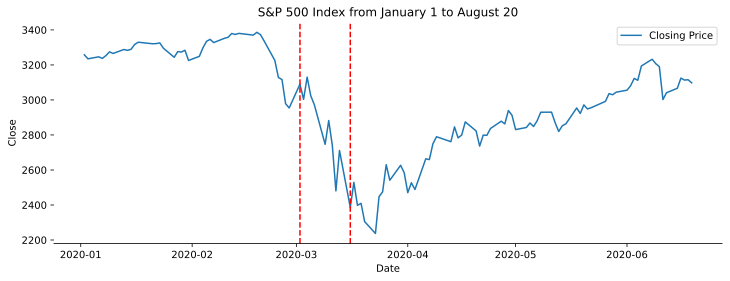

In [28]:
start_date = "2020-01-01"
end_date = "2020-06-20"
sp500 = pdr.get_data_stooq("^SPX", start=start_date, end=end_date)
sp500_close = sp500["Close"]

plt.figure(figsize=(12, 4))
plt.title("S&P 500 Index from January 1 to August 20")
sns.lineplot(data=sp500_close)
sns.despine(left=True)
plt.axvline(datetime(2020, 3, 2), color="red", linestyle="--")
plt.axvline(datetime(2020, 3, 16), color="red", linestyle="--")
plt.legend(["Closing Price"]);

Scatterplot of S&P 500 index value against COVID tweet sentiment:

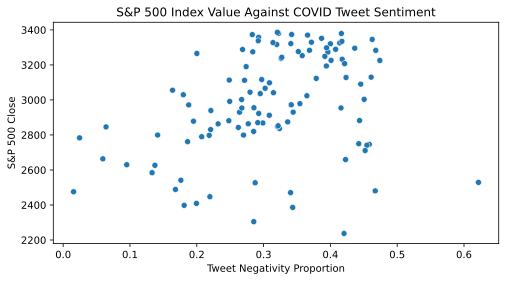

In [29]:
df = pd.concat([combined_avg_neg["Negative"], sp500_close], axis=1).dropna()
df.columns = ["Tweet Negativity Proportion", "S&P 500 Close"]

plt.figure(figsize=(8, 4))
plt.title("S&P 500 Index Value Against COVID Tweet Sentiment")
sns.scatterplot(data=df, x="Tweet Negativity Proportion", y="S&P 500 Close");

At a glance, there is no clear correlation between tweet negativity proportion and S&P 500 close. Regression analysis will be performed as the next step:

In [30]:
X = df[["Tweet Negativity Proportion"]]
y = df["S&P 500 Close"]

# Create standard scaler instance for X
scaler_X = StandardScaler()

# Fit the scaler to the data and transform X
X_standardised = scaler_X.fit_transform(X)

# Add a constant (intercept term) to X_standardised
X_standardised = sm.add_constant(X_standardised)

model_std = sm.OLS(y, X_standardised)
results = model_std.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          S&P 500 Close   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     13.53
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           0.000368
Time:                        22:17:03   Log-Likelihood:                -766.68
No. Observations:                 109   AIC:                             1537.
Df Residuals:                     107   BIC:                             1543.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2982.0748     26.533    112.389      0.0

- With an R-squared value of 0.112, we can say that approximately 11.2% of the variation in S&P 500 close price (y) can be explained COVID-19 tweets negativity proportion (x1). This is a relatively low value - the model does not explain a large portion of the variation in S&P 500 close price.

- The coefficient estimate for x1, 97.6147, suggests that for every increase of x1 by one standard deviation (x1 is standardised in the model), the model predicts an increase of 97.6147 in S&P 500 close price on average. This coefficient estimate is statistically significant even at the 0.1% level.

- The positive coefficient estimate suggests that COVID-19 tweets negativity proportion is, in fact, positively correlated with S&P 500 close price. This is curious because one may expect that higher proportions of negativity in COVID-19 tweets should result in lower S&P 500 close prices. This is very likely caused by a multitude of confounders not captured in this simple linear regression model, which results in omitted variable bias.

This is ultimately a very crude simple linear regression analysis. There are, in reality, many other variables that should be controlled for. 
A few examples may include:

- Time: Both the S&P 500 index value and COVID-19 sentiment on Twitter could vary over time. Independent variables could be included to capture linear (or nonlinear) time trends.
- Economic Indicators: Macro-economic indicators like unemployment rate or interest rates will affect the S&P 500 and COVID-19 sentiment on Twitter.
- Market volatility: Measures of market volatility, through indices like the VIX index, are important to consider as they will also impact the S&P 500 and COVID-19 sentiment on Twitter.

Further data relating to these variables will need to be collected to perform an appropriate multiple linear regression analysis.